# Práctica 3. Segmentación de imágenes
## Apertura y pasos previos

In [1]:
import numpy as np
import pydicom as pdc
import matplotlib.pyplot as plt
import cv2

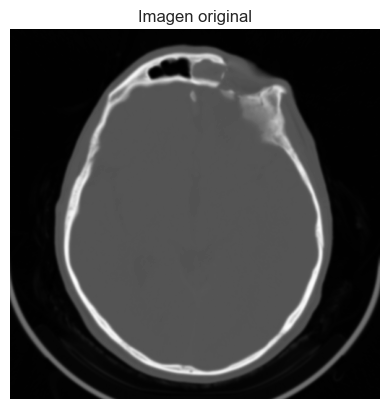

In [2]:
# Abrir la imagen
def abrir_imagen(num_imagen):
    return pdc.dcmread(fr"C:\Users\Gonzalo_MA\Desktop\Universidad\Tercero\Imagenes biomedicas\Practica 1/im{num_imagen}.dcm")

imagen = abrir_imagen(8)

# Guardar la imagen en una matriz de datos indicando los bits por pixel
def imagen_bits(imagen, bpp = 12):
    if bpp == 12:
        sol = np.array(imagen.pixel_array)
    elif bpp == 8:
        sol = (np.array(imagen.pixel_array) * (255/4095)).astype(np.uint8)
    return sol, bpp

# Creaamos la matriz de la imagen con 12 bpp
imagen_pixeles, bpp = imagen_bits(imagen, 12)

# Visualizamos la imagen
plt.imshow(imagen_pixeles, cmap = 'gray') # cmap = "gray", camp = "jet", cmap = "viridis"
plt.axis('off')
plt.title("Imagen original")
plt.show()

In [3]:
def histograma_2(imagen):
    # Calculamos las veces que aparece cada valor
    valores, cuenta = np.unique(imagen.flatten(), return_counts= True)
    # Pasamos a frecuencias relativas
    cuenta = cuenta/(512*512)
    return valores, cuenta

def linea(arg, ymax):
    plt.vlines(x = arg, ymin = 0, ymax = ymax, colors = "orange")

def ventana(imagen, vmin, vmax):
    # Clipeado de la imagen entre los umbrales
    clipeada = np.clip(imagen, a_min=vmin, a_max=vmax)
    # Reescalamiento para que la ventana ocupe todos los valores de píxeles
    clipeada = ((clipeada - vmin)/(vmax - vmin))*((2**bpp)-1)
    return clipeada.astype(np.uint16)

In [4]:
v = ventana(imagen_pixeles, 1030, 1080)

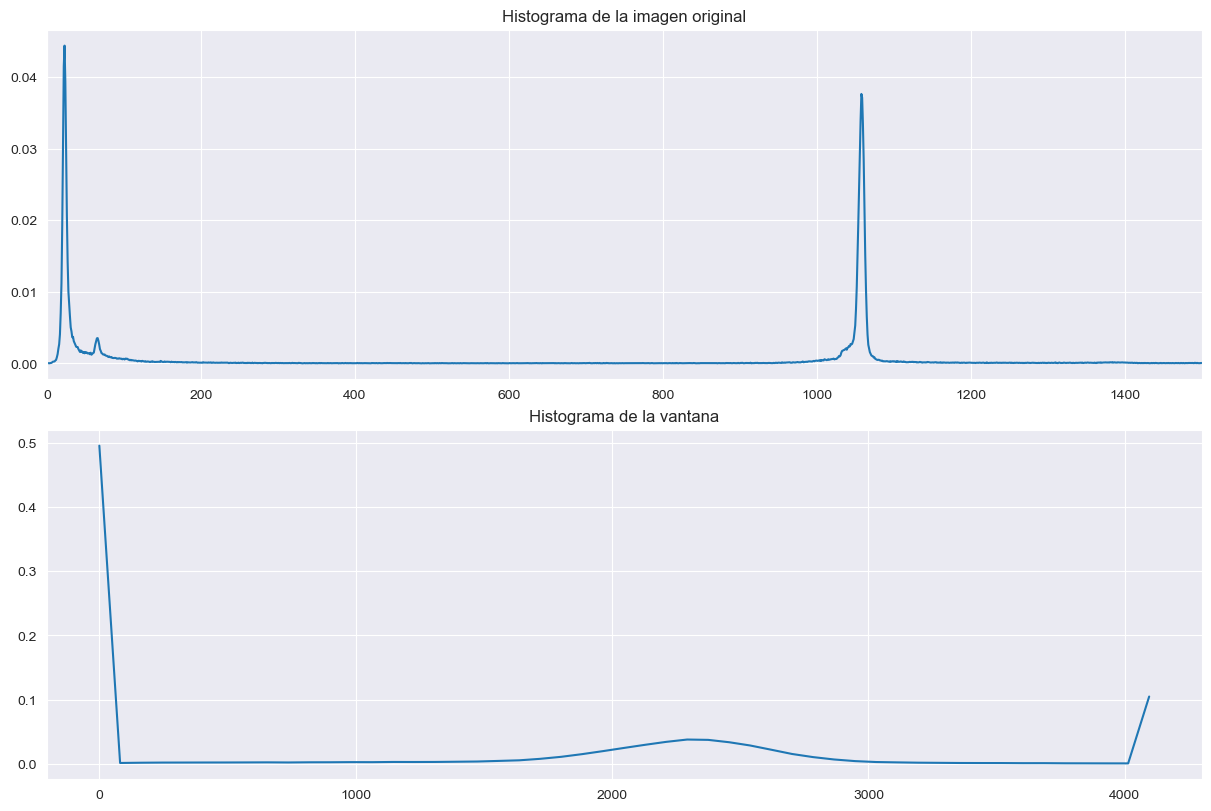

In [5]:
valores_o, cuenta_o = histograma_2(imagen_pixeles)
valores_v, cuenta_v = histograma_2(v)

_, ax = plt.subplots(2, 1, figsize = (12, 8), layout = "constrained")
ax[0].plot(valores_o, cuenta_o)
ax[0].set_title("Histograma de la imagen original")
ax[0].set(xlim=(0, 1500))
ax[1].plot(valores_v, cuenta_v)
ax[1].set_title("Histograma de la vantana")

plt.show()

## Ejercicio 1 Umbralización
### Umbralización manual (ventana)

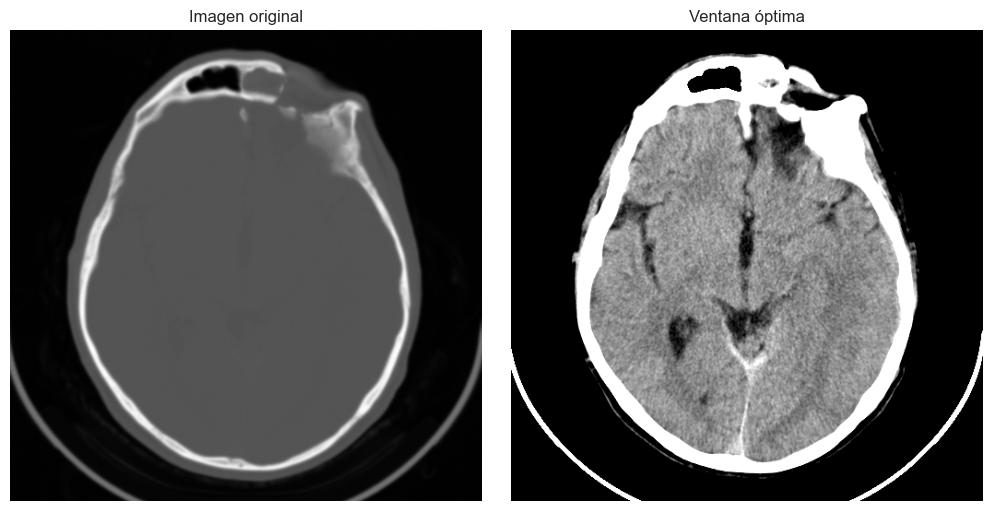

In [6]:
_, ax = plt.subplots(1, 2, figsize = (10, 5), layout = "constrained")

ax[0].imshow(imagen_pixeles, cmap="gray")
ax[0].axis("off")
ax[0].set_title("Imagen original")
ax[1].imshow(v, cmap="gray")
ax[1].axis("off")
ax[1].set_title("Ventana óptima")

plt.show()

### Umbralización automática iterativa
#### Una aplicación

In [7]:
def umb_aut(imagen, condicion):
    # Seleccionamos solo los pixeles que están en la máscara
    imagen_plana = imagen.flatten()
    condicion = condicion.flatten()
    imagen_modificada = imagen_plana[condicion]
    
    # Inicializamos la media
    val, cuen = np.unique(imagen_modificada, return_counts= True)
    val = val.tolist()
    cuen = cuen.tolist()
    
    old_mean = -5   
    mean = media(val, cuen)
    iteraciones = 0
    
    # Iteramos hasta que la diferencia entre dos medias sucesivas sea menor que 1e-5 o supere un max de iteraciones
    while abs(old_mean - mean) > 1e-5 and iteraciones < 50:
        val1 = []
        cuen1 = []
        val2 = []
        cuen2 = []
        for i in range(len(val)):
            if val[i] <= mean:
                val1 += [val[i]]
                cuen1 += [cuen[i]]
            else:
                val2 += [val[i]]
                cuen2 += [cuen[i]]
                
        # Calculamos las medias de los dos grupos
        mean1 = media(val1, cuen1)
        mean2 = media(val2, cuen2)
        
        # Actualizamos los valores
        old_mean = mean
        mean = (mean1 + mean2) / 2
        iteraciones += 1
    
    return (imagen > mean), mean

# Función auxiliar para calcular las medias
def media(values, ammount):
    suma = 0
    for x in range(len(values)):
        suma += values[x] * ammount[x]
    return suma / sum(ammount)

El umbral para la IMAGEN ORIGINAL es 624.6492681706546
El umbral para la VENTANA es 1379.5980954314907


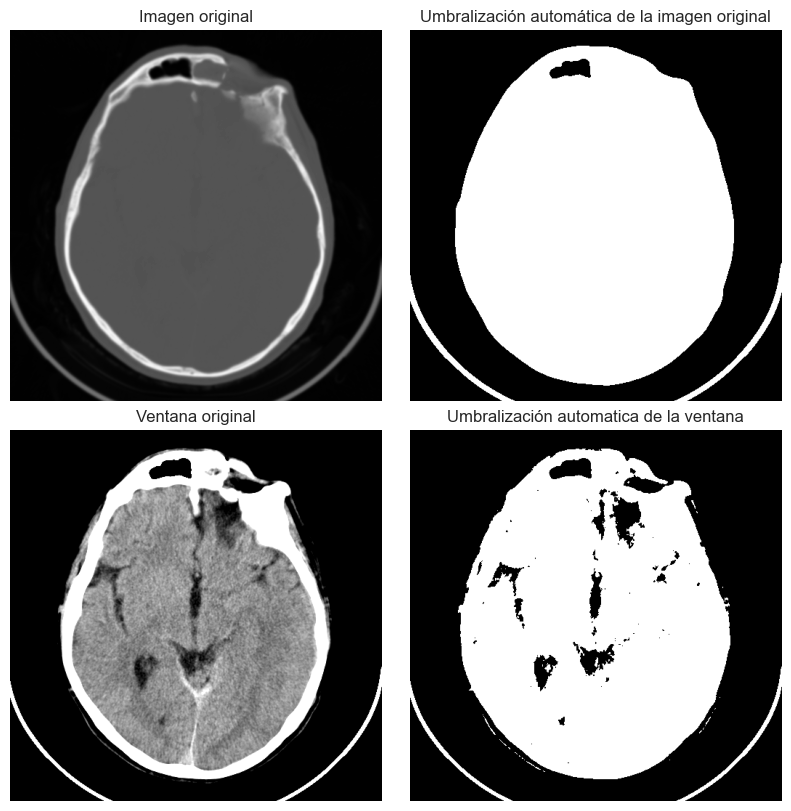

In [8]:
imagen_original_umbralizada, media_imagen_original = umb_aut(imagen_pixeles, np.ones((512, 512), dtype=bool))
ventana_umbralizada, media_ventana = umb_aut(v, np.ones((512, 512), dtype=bool))

print("El umbral para la IMAGEN ORIGINAL es", media_imagen_original)
print("El umbral para la VENTANA es", media_ventana)

_, ax = plt.subplots(2, 2, figsize = (8, 8), layout = "constrained")
ax[0,0].imshow(imagen_pixeles, cmap="gray")
ax[0,0].axis("off")
ax[0,0].set_title("Imagen original")
ax[0,1].imshow(imagen_original_umbralizada, cmap="gray")
ax[0,1].axis("off")
ax[0,1].set_title("Umbralización automática de la imagen original")
ax[1,0].imshow(v, cmap="gray")
ax[1,0].axis("off")
ax[1,0].set_title("Ventana original")
ax[1,1].imshow(ventana_umbralizada, cmap="gray")
ax[1,1].axis("off")
ax[1,1].set_title("Umbralización automatica de la ventana")

plt.show()

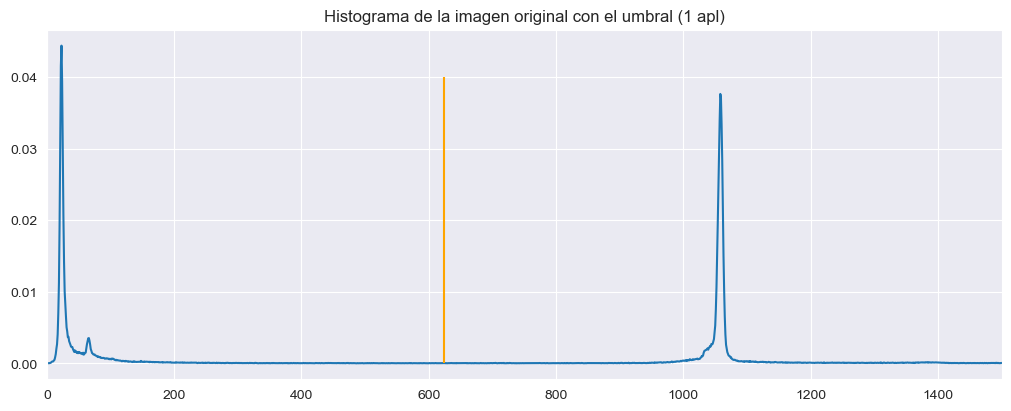

In [9]:
_, ax = plt.subplots(figsize = (10, 4), layout = "constrained")
ax.plot(valores_o, cuenta_o)
ax.set(xlim=(0, 1500))
ax.set_title("Histograma de la imagen original con el umbral (1 apl)")
linea(media_imagen_original, 0.04)

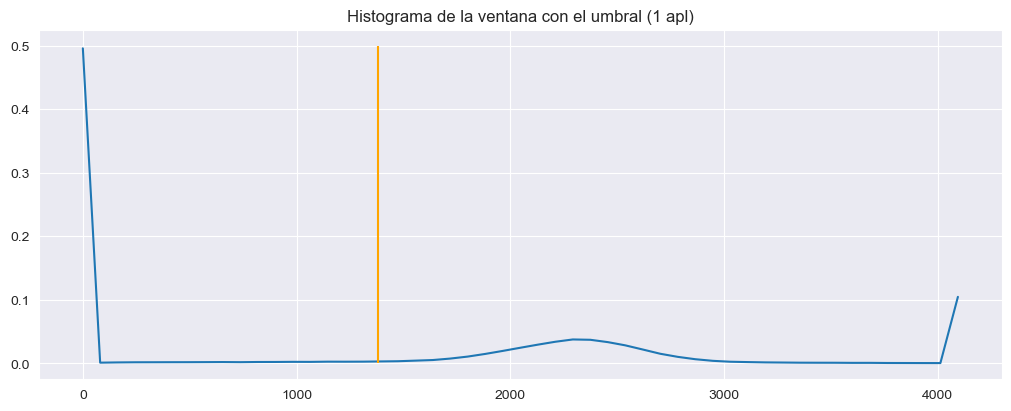

In [10]:
_, ax = plt.subplots(figsize = (10, 4), layout = "constrained")
ax.plot(valores_v, cuenta_v)
ax.set_title("Histograma de la ventana con el umbral (1 apl)")
linea(media_ventana, 0.5)

#### N-aplicaciones

In [11]:
def n_umb_aut(imagen, n):
    # Inicializamos la primera iteración con una máscara de valores True
    imagen_binaria, media_im = umb_aut(imagen, np.ones((imagen.shape[0], imagen.shape[1]), dtype=bool))
    
    # Iteramos
    for i in range(n-1):
        imagen_binaria, media_im = umb_aut(imagen, imagen_binaria)
    return imagen_binaria, media_im

El umbral para la IMAGEN ORIGINAL es 1757.6241142830033
El umbral para la VENTANA es 3162.7767269831343


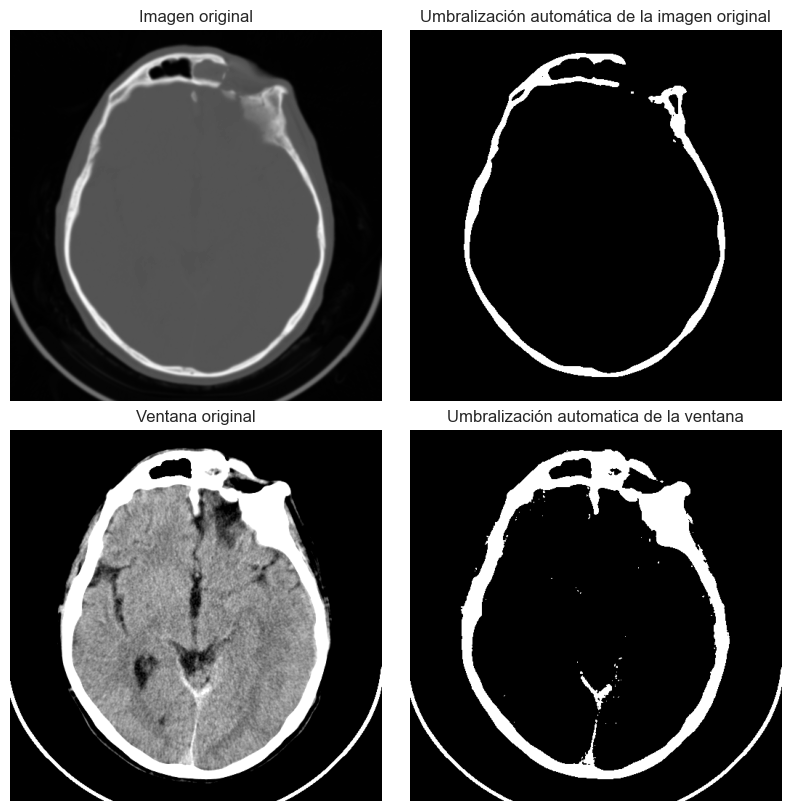

In [25]:
imagen_original_umbralizada_2, media_imagen_original_2 = n_umb_aut(imagen_pixeles, 2)
ventana_umbralizada_2, media_ventana_2 = n_umb_aut(v, 2)

print("El umbral para la IMAGEN ORIGINAL es", media_imagen_original_2)
print("El umbral para la VENTANA es", media_ventana_2)

_, ax = plt.subplots(2, 2, figsize = (8, 8), layout = "constrained")
ax[0,0].imshow(imagen_pixeles, cmap="gray")
ax[0,0].axis("off")
ax[0,0].set_title("Imagen original")
ax[0,1].imshow(imagen_original_umbralizada_2, cmap="gray")
ax[0,1].axis("off")
ax[0,1].set_title("Umbralización automática de la imagen original")
ax[1,0].imshow(v, cmap="gray")
ax[1,0].axis("off")
ax[1,0].set_title("Ventana original")
ax[1,1].imshow(ventana_umbralizada_2, cmap="gray")
ax[1,1].axis("off")
ax[1,1].set_title("Umbralización automatica de la ventana")

plt.show()

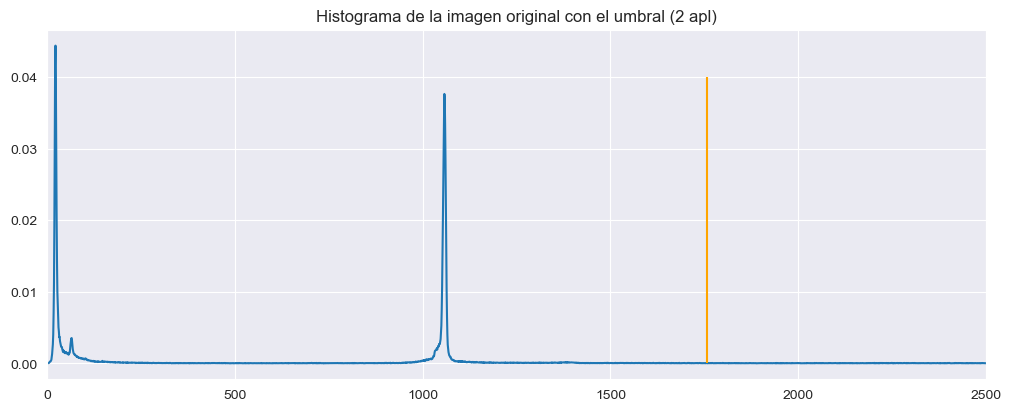

In [13]:
_, ax = plt.subplots(figsize = (10, 4), layout = "constrained")
ax.plot(valores_o, cuenta_o)
ax.set(xlim=(0, 2500))
ax.set_title("Histograma de la imagen original con el umbral (2 apl)")
linea(media_imagen_original_2, 0.04)

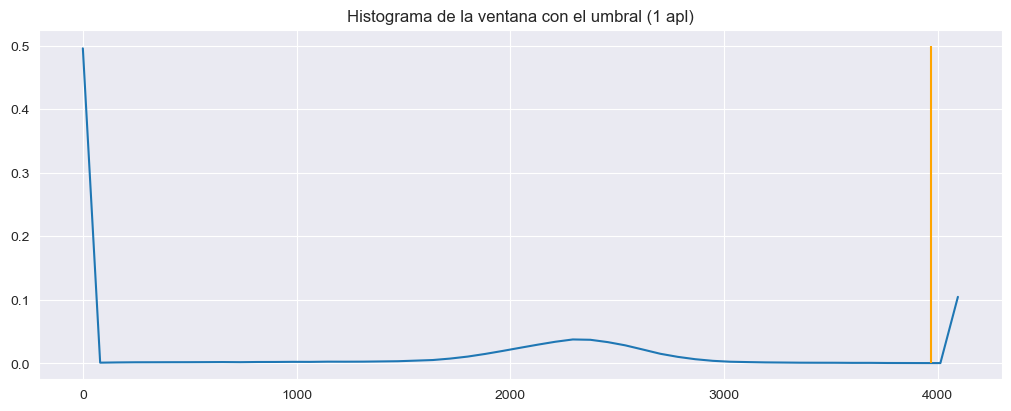

In [14]:
_, ax = plt.subplots(figsize = (10, 4), layout = "constrained")
ax.plot(valores_v, cuenta_v)
ax.set_title("Histograma de la ventana con el umbral (1 apl)")
linea(media_ventana_2, 0.5)

### Umbralización automática (filtrada)

In [16]:
def gauss(imagen, tamano = 5, desviacion = 1):
    # Creamos el kernel
    t =  tamano//2
    kernel = np.fromfunction(lambda x, y:
                             (1/ (2 * np.pi * desviacion ** 2)) * np.exp(-((x - t) ** 2 + (y - t) ** 2) / (2 * desviacion ** 2)),
                             (tamano, tamano))
    suma_kernel = np.sum(kernel)

    # Pad de la imagen e inicialización  
    im_pad = np.pad(imagen, t)
    im_filtrada = np.zeros((512, 512))

    # Aplicamos la convolucion
    for x in range(t, 512+t):
        for y in range(t, 512+t):
            im_filtrada[x-t, y-t] = (np.sum(kernel * im_pad[x-t:x+t+1, y-t:y+t+1]))/(suma_kernel)

    return im_filtrada.astype(np.uint16)

In [28]:
original_filtrada = gauss(imagen_pixeles)
ventana_filtrada = gauss(v)
original_filtrada_umbralizada_2, media_original_filtrada_2 = n_umb_aut(original_filtrada, 2)
ventana_filtrada_umbralizada_2, media_ventana_filtrada_2 = umb_aut(ventana_filtrada, np.ones((512, 512), dtype=bool))

print("El umbral para la IMAGEN ORIGINAL es", media_original_filtrada_2)
print("El umbral para la VENTANA es", media_ventana_filtrada_2)

El umbral para la IMAGEN ORIGINAL es 1722.4534569931457
El umbral para la VENTANA es 1372.1686281475731


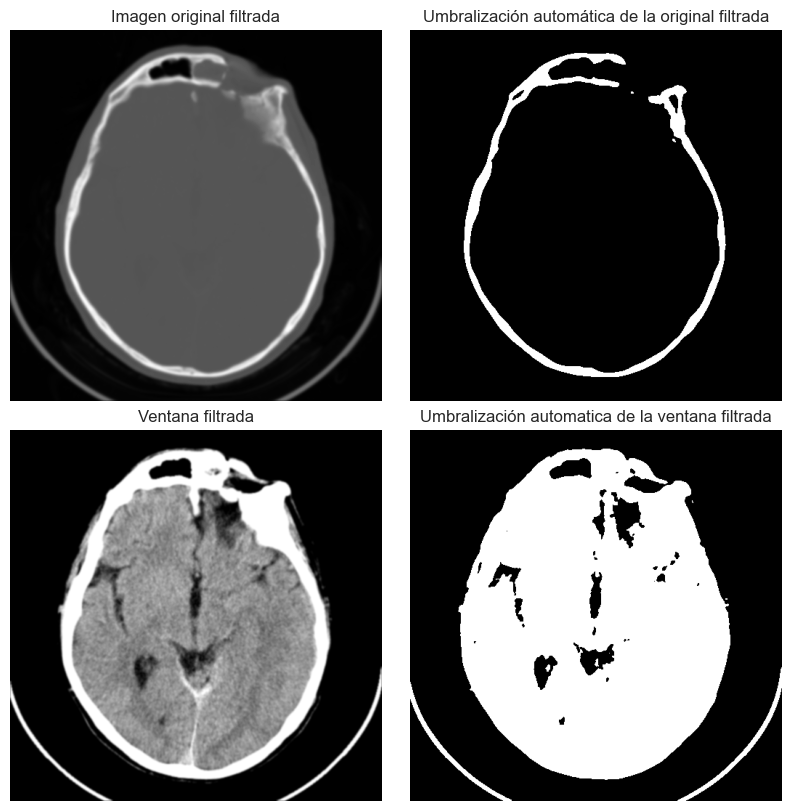

In [29]:
_, ax = plt.subplots(2, 2, figsize = (8, 8), layout = "constrained")
ax[0,0].imshow(original_filtrada, cmap="gray")
ax[0,0].axis("off")
ax[0,0].set_title("Imagen original filtrada")
ax[0,1].imshow(original_filtrada_umbralizada_2, cmap="gray")
ax[0,1].axis("off")
ax[0,1].set_title("Umbralización automática de la original filtrada")
ax[1,0].imshow(ventana_filtrada, cmap="gray")
ax[1,0].axis("off")
ax[1,0].set_title("Ventana filtrada")
ax[1,1].imshow(ventana_filtrada_umbralizada_2, cmap="gray")
ax[1,1].axis("off")
ax[1,1].set_title("Umbralización automatica de la ventana filtrada")

plt.show()

### Comparación

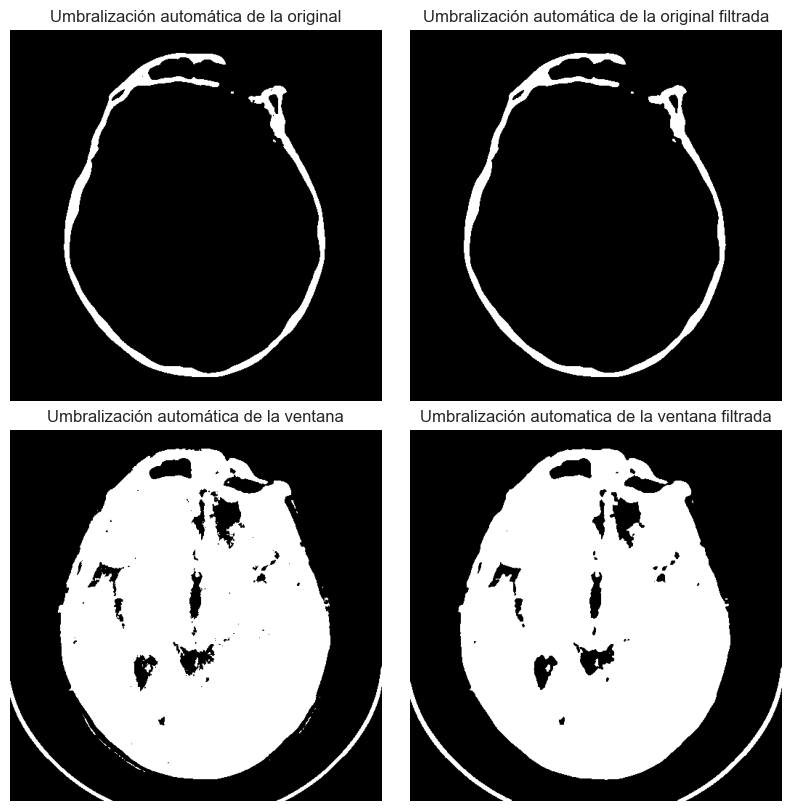

In [31]:
_, ax = plt.subplots(2, 2, figsize = (8, 8), layout = "constrained")
ax[0,0].imshow(imagen_original_umbralizada_2, cmap="gray")
ax[0,0].axis("off")
ax[0,0].set_title("Umbralización automática de la original")
ax[0,1].imshow(original_filtrada_umbralizada_2, cmap="gray")
ax[0,1].axis("off")
ax[0,1].set_title("Umbralización automática de la original filtrada")
ax[1,0].imshow(ventana_umbralizada, cmap="gray")
ax[1,0].axis("off")
ax[1,0].set_title("Umbralización automática de la ventana")
ax[1,1].imshow(ventana_filtrada_umbralizada_2, cmap="gray")
ax[1,1].axis("off")
ax[1,1].set_title("Umbralización automatica de la ventana filtrada")

plt.show()

## Ejercicio 2
### SLIC sobre la imagen original

In [32]:
# Inicializamos las imagenes en 8bpp
imagen_8bpp, _ = imagen_bits(imagen, 8)

# Configuramos los parámetros del algoritmo SLIC
tam_superpixeles_o = 10
compacidad_o = 5

# Creamos el objeto SLIC
slic_o = cv2.ximgproc.createSuperpixelSLIC(imagen_8bpp, region_size=tam_superpixeles_o, ruler=compacidad_o)

# Realizamos la segmentación
slic_o.iterate(100)

# Obtenemos máscara de contornos de superpíxeles
mascara_contornos_o = slic_o.getLabelContourMask()

# Pintamos los contornos de los superpíxeles en la imagen original
resultado_o = cv2.cvtColor(imagen_8bpp, cv2.COLOR_BGR2RGB)
resultado_o[mascara_contornos_o > 0] = [0, 255, 255]  # Color de los contornos

### SLIC sobre la ventana

In [33]:
# Inicializamos las imagenes en 8bpp
ventana_8bpp = (v * (255/4095)).astype(np.uint8)

# Configurar los parámetros del algoritmo SLIC
num_superpixeles_v = 12
compacidad_v = 1

# Crear el objeto SLIC
slic_v = cv2.ximgproc.createSuperpixelSLIC(ventana_8bpp, region_size=num_superpixeles_v, ruler=compacidad_v)

# Realizar la segmentación
slic_v.iterate(20)

# Obtener máscara de contornos de superpíxeles
mascara_contornos_v = slic_v.getLabelContourMask()

# Pintar los contornos de los superpíxeles en la imagen original
resultado_v = cv2.cvtColor(ventana_8bpp, cv2.COLOR_BGR2RGB)
resultado_v[mascara_contornos_v > 0] = [0, 255, 255]  # Color de los contornos 

### Visualización

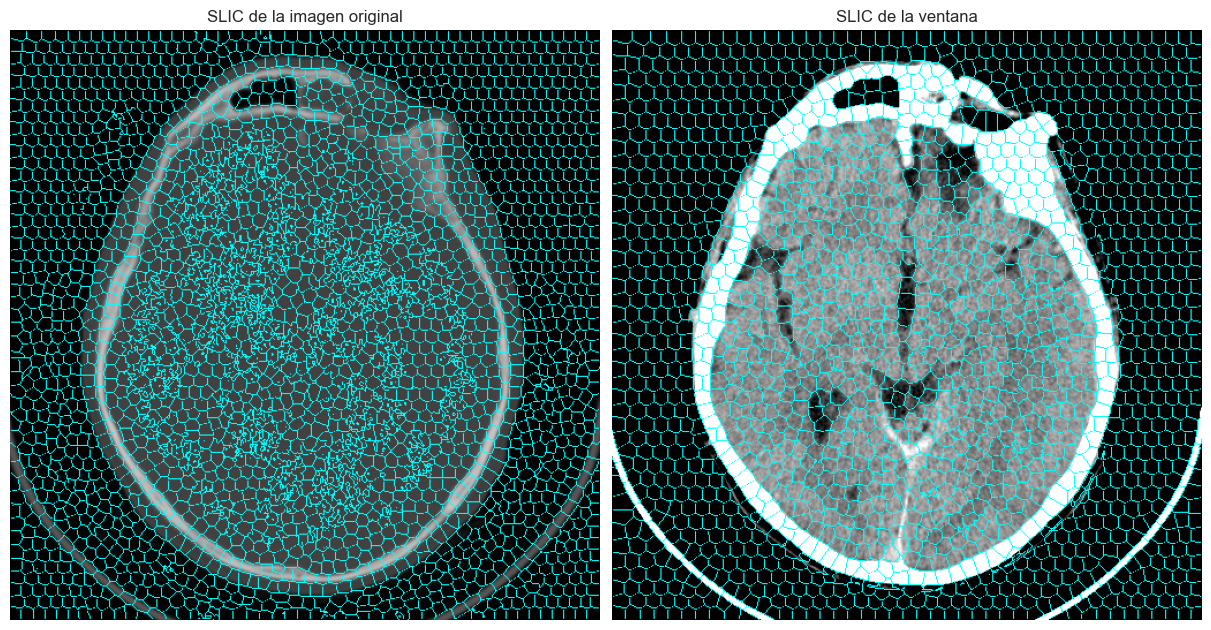

In [22]:
_, ax = plt.subplots(1, 2, figsize = (12, 8), layout = "constrained")
ax[0].imshow(resultado_o, cmap="gray")
ax[0].axis("off")
ax[0].set_title("SLIC de la imagen original")
ax[1].imshow(resultado_v, cmap="gray")
ax[1].axis("off")
ax[1].set_title("SLIC de la ventana")

plt.show()

In [23]:
labels = slic_o.getLabels()

# Crear una imagen con los superpíxeles coloreados
colores_unicos = np.random.randint(0, 255, size=(np.max(labels) + 1, 3), dtype=np.uint8)
superpixeles_coloreados = colores_unicos[labels]

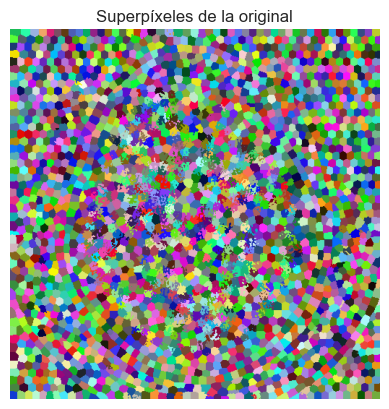

In [34]:
plt.imshow(superpixeles_coloreados)
plt.axis("off")
plt.grid(False)
plt.title("Superpíxeles de la original")
plt.show()